# Loading and Preprocessing Data with TensorFlow:

- When training TensorFlow models on large datasets, use TensorFlow’s own data loading and preprocessing API, called `tf.data`:

  - It is capable of loading and preprocessing data extremely efficiently, reading from multiple files in parallel using multithreading and queuing, shuffling and batching samples.
  - It can do all of this on the fly: It loads and preprocesses the next batch of data across multiple CPU cores, while your GPUs or TPUs are busy training the current batch of data.
  - The `tf.data` API lets you handle datasets that do not fit in memory, and it allows you to make full use of your hardware resources, thereby speeding up training.
  - The `tf.data` API can read text files such as CSVs, binary files w/ fixed-size records, and binary files that use TensorFlow's TFRecord format, w/c supports records of varying sizes.
  - The `tf.data` API has support for reading from SQL databases.
  - The `tf.data` API is a streaming API: you can very efficiently iterate through the dataset's items, but the API is not designed for indexing or slicing.

  <br><br>

  - `TFRecord` is a flexible and efficient binary format usually containing protocol buffers (an open source binary format).

- Keras comes w/ preprocessing layers that can be embedded in models:
  - When deploying a model to production, it will be able to ingest raw data directly, w/o having to add any additional preprocessing code. This eliminates the risk of mismatch between the preprocessing code used during training and the preprocessing code used in production, which would likely cause training/serving skew.
  - If you deploy your model in multipleapps coded in different programming languages, you won’t have to reimplement thesame preprocessing code multiple times, which also reduces the risk of mismatch.


# A. `tf.data` API:

- `tf.data.Dataset`:
  - Represents a sequence of data items.
  - When slicing a tuple, a dictionary, or a nested structure, the dataset will only slice the tensors it contains, while preserving the tuple/dictionary structure.


In [1]:
import tensorflow as tf

In [2]:
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [3]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [4]:
X_nested = {"a": ([1, 2, 3], [4, 5, 6]), "b": [7, 8, 9]}
dataset = tf.data.Dataset.from_tensor_slices(X_nested)
for item in dataset:
    print(item)

{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=4>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=7>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=5>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=8>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=6>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=9>}


### A.1. Chaining Transformers:

- Once you have a dataset, you can apply all sorts of transformations to it by calling its transformation methods.
  - Each method returns a new dataset, so you can chain transformations. The dataset methods do not modify datasets - they create new ones.


In [5]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In [6]:
dataset = dataset.map(lambda x: x * 2)  # x is a batch
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


In [7]:
dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 50)
for item in dataset:
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)


In [8]:
# take a look at 2 items from a dataset
for item in dataset.take(2):
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)


### A.2. Shuffling the Data:

- Gradient descent works best when the instances in the training set are independent and identically distributed (IID). A simple way to ensure this is to shuffle the instances, using the `shuffle()` method.

- `shuffle()` method:

  - Create a new dataset that will start by filling up a buffer w/ the first items of the source dataset.
  - Then, whenever it is asked for an item, it will pull one out randomly from the buffer and replace it with a fresh one from the source dataset, until it has iterated entirely through the source dataset.
  - At this point it will continue to pull out items randomly from the buffer until it is empty.
  - You must specify the buffer size, and it is important to make it large enough, or else shuffling will not be very effective.Just don’t exceed the amount of RAM you have, though even if you have plenty of it, there’s no need to go beyond the dataset’s size.

- For a large dataset that does not fit in memory, this simple shuffling-buffer approach may not be sufficient, since the buffer will be small compared to the dataset. One solution is to shuffle the source data itself.
  - Even if the source data is shuffled, you will usually want to shuffle it some more, or else the same order will be repeated at each epoch, and the model may end up being biased (e.g., due to some spurious patterns present by chance in the source data’s order).
  - To shuffle the instances some more, a common approach is to split the source data into multiple files, then read them in a random order during training.
  - However, instances located in the same file will still end up close to each other. To avoid this you can pick multiple files randomly and read them simultaneously, interleaving their records.
  - Then on top of that you can add a shuffling buffer using the `shuffle()` method.


In [9]:
dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([1 4 2 3 5 0 6], shape=(7,), dtype=int64)
tf.Tensor([9 8 2 0 3 1 4], shape=(7,), dtype=int64)
tf.Tensor([5 7 9 6 7 8], shape=(6,), dtype=int64)


### A.3. Interleaving lines from multiple files:

- `tf.data.Dataset.list_files(train_filepaths)`:

  - `lift_file()` function returns a dataset that shuffles the filepaths. (can be turned off, `shuffle=False`)

- `interleave()`:

  - This method when applied to an instance of `list_files()` will read from `cycle_length` no. of files at a a time and interleave their lines:
    - This will create a dataset that will pull `cycle_length` no of filepaths from the instance of the `list_files`
    - And for each one, it will call the function you gave it to create a new dataset.
    - For interleaving to work best, it is preferable to have files of identical length; otherwise the end of the longest file will not be interleaved.
  - By default, does not use parallelism; it just reads one line at a time from each file, sequentially.
    - To read the files in parallel, set the argment `num_parallel_calls` to the number of threads you want or set it to `tf.data.AUTOTUNE` to make tensor flow choose the right number of threads dynamically based on the available CPU.

- For a very large dataset that does not fit in memory, you will typically want to split it into many files first, then have TensorFlow read these files in parallel.


In [10]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

In [11]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42
)

In [12]:
import numpy as np
from pathlib import Path

In [13]:
# Split the dataset and save it to 20 csv files:
def save_to_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = Path() / "datasets" / "housing"
    housing_dir.mkdir(parents=True, exist_ok=True)
    filename_format = "my_{}_{:02d}.csv"

    filepaths = []
    m = len(data)
    chunks = np.array_split(np.arange(m), n_parts)
    for file_idx, row_indices in enumerate(chunks):
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        filepaths.append(str(part_csv))
        with open(part_csv, "w") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths


train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)

In [14]:
print("".join(open(train_filepaths[0]).readlines()[:4]))

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621



In [15]:
train_filepaths

['datasets\\housing\\my_train_00.csv',
 'datasets\\housing\\my_train_01.csv',
 'datasets\\housing\\my_train_02.csv',
 'datasets\\housing\\my_train_03.csv',
 'datasets\\housing\\my_train_04.csv',
 'datasets\\housing\\my_train_05.csv',
 'datasets\\housing\\my_train_06.csv',
 'datasets\\housing\\my_train_07.csv',
 'datasets\\housing\\my_train_08.csv',
 'datasets\\housing\\my_train_09.csv',
 'datasets\\housing\\my_train_10.csv',
 'datasets\\housing\\my_train_11.csv',
 'datasets\\housing\\my_train_12.csv',
 'datasets\\housing\\my_train_13.csv',
 'datasets\\housing\\my_train_14.csv',
 'datasets\\housing\\my_train_15.csv',
 'datasets\\housing\\my_train_16.csv',
 'datasets\\housing\\my_train_17.csv',
 'datasets\\housing\\my_train_18.csv',
 'datasets\\housing\\my_train_19.csv']

In [16]:
# Build an input pipeline:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

# The filepaths are now shuffled
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets\\housing\\my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_17.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_13.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_15.csv', sh

In [17]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1), cycle_length=n_readers
)

In [18]:
for line in dataset.take(5):
    print(line)

tf.Tensor(b'4.5909,16.0,5.475877192982456,1.0964912280701755,1357.0,2.9758771929824563,33.63,-117.71,2.418', shape=(), dtype=string)
tf.Tensor(b'2.4792,24.0,3.4547038327526134,1.1341463414634145,2251.0,3.921602787456446,34.18,-118.38,2.0', shape=(), dtype=string)
tf.Tensor(b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67', shape=(), dtype=string)
tf.Tensor(b'2.1856,41.0,3.7189873417721517,1.0658227848101265,803.0,2.0329113924050635,32.76,-117.12,1.205', shape=(), dtype=string)
tf.Tensor(b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215', shape=(), dtype=string)


### A.4. Preprocessing the Data:


In [19]:
X_train.shape

(11610, 8)

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [21]:
X_mean, X_std = scaler.mean_, scaler.scale_
n_inputs = 8


def parse_csv_line(line):
    defs = [0.0] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])


def preprocess(line):
    x, y = parse_csv_line(line)
    return (x - X_mean) / X_std, y

In [22]:
preprocess(b"4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782")

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579159,  1.216324  , -0.05204564, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

### A.5. Putting Everything Together:

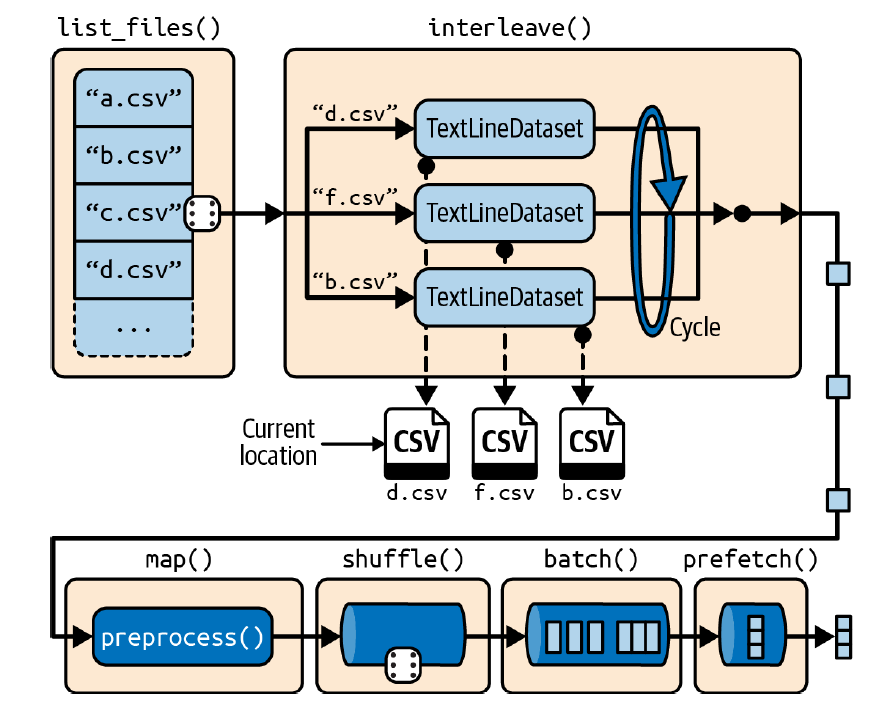


In [23]:
def csv_reader_dataset(
    filepaths,
    n_readers=5,
    n_read_threads=None,
    n_parse_threads=5,
    shuffle_buffer_size=10_000,
    seed=42,
    batch_size=32,
):
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers,
        num_parallel_calls=n_read_threads,
    )
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    return dataset.batch(batch_size).prefetch(1)

In [24]:
# sample
example_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in example_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[-1.3957452  -0.04940685 -0.22830808  0.22648273  2.2593622   0.35200632
   0.9667386  -1.4121602 ]
 [ 2.7112627  -1.0778131   0.69413143 -0.14870553  0.51810503  0.3507294
  -0.82285154  0.80680597]
 [-0.13484643 -1.868895    0.01032507 -0.13787179 -0.12893449  0.03143518
   0.2687057   0.13212144]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.819]
 [3.674]
 [0.954]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[ 0.09031774  0.9789995   0.1327582  -0.13753782 -0.23388447  0.10211545
   0.97610843 -1.4121602 ]
 [ 0.05218809 -2.0271113   0.2940109  -0.02403445  0.16218767 -0.02844518
   1.4117942  -0.93737936]
 [-0.672276    0.02970133 -0.76922584 -0.15086786  0.4962024  -0.02741998
  -0.7853724   0.77182245]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[2.725]
 [1.205]
 [1.625]], shape=(3, 1), dtype=float32)



In [25]:
# Methods of tf.data.Dataset Class
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● bucket_by_sequence_length()A transformation that buckets elements in a `Dataset` by length.
● cache()              Caches the elements in this dataset.
● cardinality()        Returns the cardinality of the dataset, if known.
● choose_from_datasets()Creates a dataset that deterministically chooses elements from `datasets`.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()           Maps `map_func` across this dataset and flattens the result.
● from_generator()     Create

### A.6. Prefetching:

- `.prefetch(n)` :

  - Create a dataset that will do its best to always be `n` batch ahead:

    - While the training algorithm is working on `n` batch, the dataset will be working in parallel on getting the next batch ready (e.g., reading the data from disk and preprocessing it)
    - This can improve performance dramatically:<br>
      &emsp; 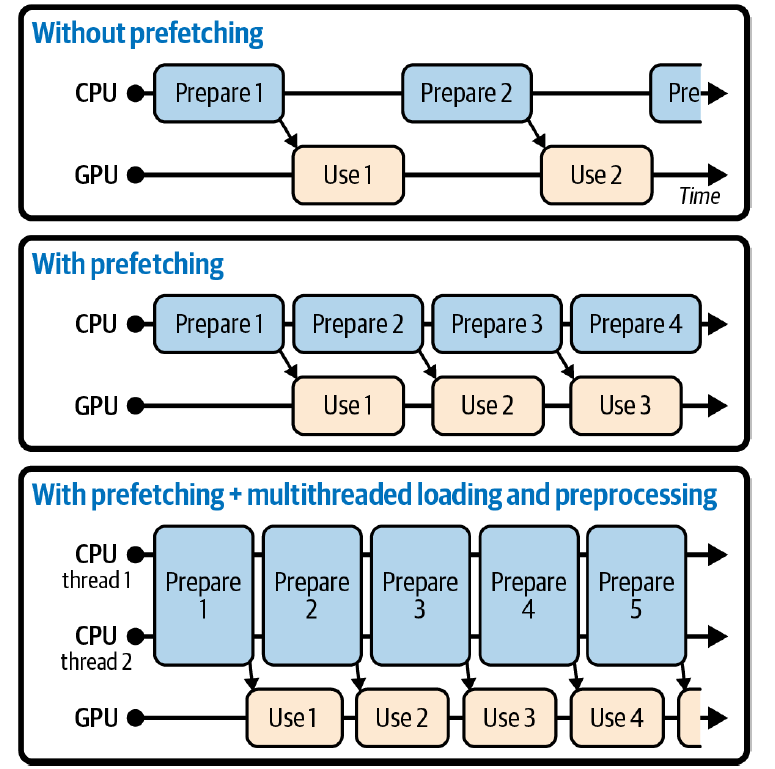 <br>

  - If we ensure that loading and preprocessing are multithreaded (by setting `num_parallel_calls` when calling `interleave()` and `map()`), we can exploit multiple CPU cores and hopefully make preparing one batch of data shorter than running a training step on the GPU: this way the GPU will be almost 100% utilized (except for the data transfer time from the CPU to the GPU), and training will run much faster.
  - If the dataset is small enought to fit in memory, you can significantly speed up training by using the dataset's `cache()` method to create its content to RAM.
    - Generally, this should be done after loading and preprocessing the data, but before shuffling, repeating, batching , and prefetching. This way, each instance will only be read and preprocessed once (instead of once per epoch), but the data will still be shuffled differently at each epoch, and the next batch will still be prepared in advance.


### A.7. Using the Dataset with Keras:

- In Keras, the `steps_per_execution` argument of the `compile()` method lets you define the number of batches that the `fit()` method will process during each call to the `tf.function` it uses for training.
  - The default is just 1, so if you set it to 50 you will often see a significant performance improvement.
  - However, the `on_batch_*()` methods of Keras callbacks will only be called every 50 batches.


In [26]:
train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [27]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [28]:
# Using the dataset with keras
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(
            30,
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=X_train.shape[1:],
        ),
        tf.keras.layers.Dense(1),
    ]
)
model.compile(loss="mse", optimizer="sgd")
model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
    360/Unknown - 2s 3ms/step - loss: 1.5100

363/363 [==============================] - 4s 9ms/step - loss: 1.5037 - val_loss: 0.5276
Epoch 2/5
363/363 [==============================] - 2s 4ms/step - loss: 0.5544 - val_loss: 9.3470
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.5888 - val_loss: 31.2141
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.6915 - val_loss: 8.0135
Epoch 5/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4970 - val_loss: 0.3952


In [29]:
test_mse = model.evaluate(test_set)
new_set = test_set.take(3)  # pretend we have 3 new samples
y_pred = model.predict(new_set)  # or you could just pass a NumPy array

     84/Unknown - 0s 3ms/step - loss: 0.4105

3/3 [==============================] - 0s 23ms/step


In [30]:
# Custom Training Loop
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error

n_epochs = 5
for epoch in range(n_epochs):
    for X_batch, y_batch in train_set:
        #  perform one Gradient Descent step
        print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Epoch 5/5

In [31]:
# TF function that trains the model for a whole epoch:
@tf.function
def train_one_epoch(model, optimizer, loss_fn, train_set):
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))


optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error
for epoch in range(n_epochs):
    print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
    train_one_epoch(model, optimizer, loss_fn, train_set)

Epoch 5/5

# B. TFRecord Format:

- TensorFlow's preferred format for storing large amounts of data and reading it efficiently.
- It is a very simple binary format that just contains a sequence of binary records of varying sizes (each record is comprised of a length, a CRC checksum to check that the length was not corrupted, then the actual data, and finally a CRC checksum for the data).
- A TFRecord file can be created using `tf.io.TFRecordWriter` class and then use a `tf.data.TFRecordDataset` to read one or more TFRecord files.
  - By default, a `TFRecordDataset` will read files one by one, but you can make it read multiple files in parallel and interleave their records by passing the constructor a list of filepaths and setting `num_parallel_reads` to a number greater than one. Alternatively, you could obtain the same result by using `list_files()` and `interleave()`.


In [32]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [33]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


In [34]:
# How to read multiple files in parallel and interleave them
filepaths = ["my_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


### B.1. Compressed TFRecord Files:

- It can sometimes be useful to compress your TFRecord files, especially if they need to be loaded via a network connection:


In [35]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"Compress, compress, compress!")

In [36]:
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"], compression_type="GZIP")

In [37]:
for item in dataset:
    print(item)

tf.Tensor(b'Compress, compress, compress!', shape=(), dtype=string)


### B.2. Protocol Buffers:

- Even though each record can use any binary format, TFRecord files usually contain serialized protocol buffers (also called protobufs).
- Serialized Protocol Buffers is a protable, extensible, and efficient binary format.
  - Example: <br>
    &emsp; 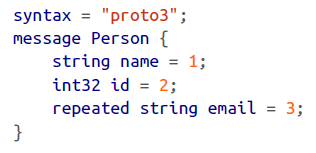 <br>


In [38]:
%%writefile person.proto
syntax = "proto3";
message Person {
    string name = 1;
    int32 id = 2;
    repeated string email = 3;
}

Overwriting person.proto


In [39]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [40]:
%ls person*

 Volume in drive D is DATA
 Volume Serial Number is F273-AA6F

 Directory of d:\Notes\git local repo\ds-proj-remote\HOML__sklearn_keras_tf

28/11/2023  12:42 PM                92 person.desc
28/11/2023  12:42 PM               114 person.proto
28/11/2023  12:42 PM               986 person_pb2.py
               3 File(s)          1,192 bytes
               0 Dir(s)  303,718,633,472 bytes free


In [41]:
from person_pb2 import Person

person = Person(name="Al", id=123, email=["abc@c.com"])
print(person)

name: "Al"
id: 123
email: "abc@c.com"



In [42]:
person.name

'Al'

In [43]:
person.name = "Alice"
person.name

'Alice'

In [44]:
person.email[0]

'abc@c.com'

In [45]:
person.email.append("c@d.com")
person.email

['abc@c.com', 'c@d.com']

In [46]:
serialized = person.SerializeToString()  # serialize person to a byte string
serialized

b'\n\x05Alice\x10{\x1a\tabc@c.com\x1a\x07c@d.com'

In [47]:
person2 = Person()

In [48]:
person2.ParseFromString(serialized)  # # parse the byte string

29

In [49]:
person == person2

True

In [50]:
person2.name

'Alice'

In [51]:
# Custom Protobuf
person_tf = tf.io.decode_proto(
    bytes=serialized,
    message_type="Person",
    field_names=["name", "id", "email"],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source="person.desc",
)

person_tf.values

[<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([123])>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'abc@c.com', b'c@d.com'], dtype=object)>]

### B.3. TensorFlow Protobufs:

* The main protobuf typically used in a TFRecord file is the `Example` protobuf, w/c represents one instance in a dataset. It contains a list of named features, where each feature can either be a list of byte strings, a list of floats, or a list of integers.
    * `tf.train.Example` protobuf definition:
    * ```proto
        syntax = "proto3";

        message BytesList { repeated bytes value = 1; }
        message FloatList { repeated float value = 1 [packed = true]; }
        message Int64List { repeated int64 value = 1 [packed = true]; }
        message Feature {
            oneof kind {
                BytesList bytes_list = 1;
                FloatList float_list = 2;
                Int64List int64_list = 3;
            }
        };
        message Features { map<string, Feature> feature = 1; };
        message Example { Features features = 1; };
    ```


In [52]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

In [53]:
person_example = Example(
    features = Features(
        feature={
            "name": Feature(bytes_list = BytesList(value=[b'Alice'])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b'abc@c.com', b'c@d.com']))
        }
    )
)

In [54]:
with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    for _ in range(5):
        f.write(person_example.SerializeToString())

### B.4. Loading and Parsing Examples:

* `tf.io.parse_single_example()`:
    * parse examples one by one
    * Fixed-length features are parsed as regular tensors, but variable-length features are parsed as sparse tensors.

* `tf.io.parse_example()`:
    * parse examples by batch

* `BytesList`:
    * Can contain any binary data you want, including any serialized object.
    * 

In [55]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}

def parse(serialized_example):
    return tf.io.parse_single_example(serialized_example, feature_description)

dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).map(parse)
for parsed_example in dataset:
    print(parsed_example)

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x00000189BB362AD0>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x00000189BB362CE0>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x00000189BB363CA0>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x00000189BB363BE0>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x00000189BB3633D0>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, '

In [56]:
#convert a sparse tensor to a dense tensor.
tf.sparse.to_dense(parsed_example['emails'], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'abc@c.com', b'c@d.com'], dtype=object)>

In [57]:
#access sparse_tensor values
parsed_example['emails'].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'abc@c.com', b'c@d.com'], dtype=object)>

In [58]:
def parse(serialized_example):
    return tf.io.parse_example(serialized_example, feature_description)

dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(2).map(parse)
for parsed_examples in dataset:
    print(parsed_examples)  # two examples at a time

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x00000189BB357E80>, 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123], dtype=int64)>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x00000189BB547DC0>, 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123], dtype=int64)>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x00000189BB39AAA0>, 'id': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([123], dtype=int64)>, 'name': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>}


In [59]:
parsed_examples

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x189bb39aaa0>,
 'id': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([123], dtype=int64)>,
 'name': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>}

### B.5. Storing Images and Tensors in TFRecords

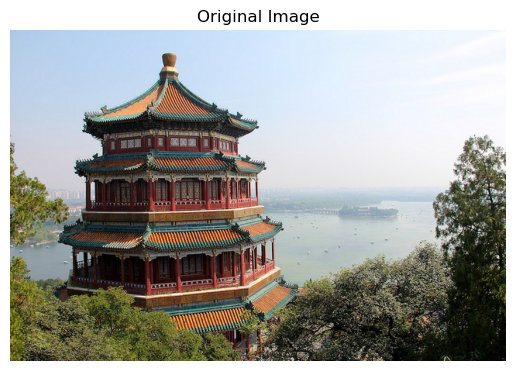

In [60]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images

img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("Original Image");

In [61]:
data = tf.io.encode_jpeg(img)
example_with_image = Example(
    features=Features(
        feature={
            "image": Feature(bytes_list=BytesList(value=[data.numpy()]))}))

serialized_example = example_with_image.SerializeToString()
with tf.io.TFRecordWriter("my_image.tfrecord") as f:
    f.write(serialized_example)

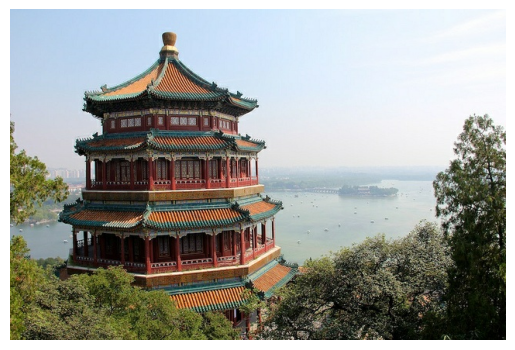

In [62]:
feature_description = { "image": tf.io.VarLenFeature(tf.string) }

def parse(serialized_example):
    example_with_image = tf.io.parse_single_example(serialized_example, feature_description)
    return tf.io.decode_jpeg(example_with_image["image"].values[0])
    # or you can use tf.io.decode_image() instead

dataset = tf.data.TFRecordDataset("my_image.tfrecord").map(parse)
for image in dataset:
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [63]:
tensor = tf.constant([[0., 1.], [2., 3.], [4., 5.]])
serialized = tf.io.serialize_tensor(tensor)
serialized

<tf.Tensor: shape=(), dtype=string, numpy=b'\x08\x01\x12\x08\x12\x02\x08\x03\x12\x02\x08\x02"\x18\x00\x00\x00\x00\x00\x00\x80?\x00\x00\x00@\x00\x00@@\x00\x00\x80@\x00\x00\xa0@'>

In [64]:
tf.io.parse_tensor(serialized, out_type=tf.float32)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 1.],
       [2., 3.],
       [4., 5.]], dtype=float32)>

In [65]:
sparse_tensor = parsed_example["emails"]
serialized_sparse = tf.io.serialize_sparse(sparse_tensor)
serialized_sparse

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'\x08\t\x12\x08\x12\x02\x08\x02\x12\x02\x08\x01"\x10\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00',
       b'\x08\x07\x12\x04\x12\x02\x08\x02"\x12\t\x07abc@c.comc@d.com',
       b'\x08\t\x12\x04\x12\x02\x08\x01"\x08\x02\x00\x00\x00\x00\x00\x00\x00'],
      dtype=object)>

In [66]:
BytesList(value=serialized_sparse.numpy())

value: "\010\t\022\010\022\002\010\002\022\002\010\001\"\020\000\000\000\000\000\000\000\000\001\000\000\000\000\000\000\000"
value: "\010\007\022\004\022\002\010\002\"\022\t\007abc@c.comc@d.com"
value: "\010\t\022\004\022\002\010\001\"\010\002\000\000\000\000\000\000\000"

### B.6. Handling Lists of Lists Using the `SequenceExample` Protobuf:

* Definition of the `SequenceExample` protobuf:

    ```proto
    syntax = "proto3";

    message FeatureList { repeated Feature feature = 1; };
    message FeatureLists { map<string, FeatureList> feature_list = 1; };
    message SequenceExample {
        Features context = 1;
        FeatureLists feature_lists = 2;
    };
    ```

* `SequenceExample`:
    * It contains a `Features` object for the contextual data and a `FeatureLists` object that contains one or more named `FeatureList` objects.
    * Each `FeatureList` caontains a list of `Feature` objects, each of which may be a list of byte strings,a list of 64-int, or a list of floats.
    * Use `tf.io.parse_single_sequence_example()` to parse a single `SequenceExample` or `tf.io.parse_sequence_example()` to parse a batch. Both functions return a tuple containing the context features (as a dictionary) and the feature lists (also a dictionary). If the feature lists contain sequences of varying sizes, convert them to ragged tensors using `tf.RaggedTensor.from_sparse()`.
    

In [67]:
from tensorflow.train import FeatureList, FeatureLists, SequenceExample

context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])),
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
})

content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8")
                                               for word in words]))

content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]
            
sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(feature_list={
        "content": FeatureList(feature=content_features),
        "comments": FeatureList(feature=comments_features)
    }))

In [68]:
sequence_example

context {
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "comments"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "hurlyburly"
          value: "\'s"
          value: "done"
          value: "."
        }
      }
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "battle"
          value: "\'s"
          value: "lost"
          value: "and"
          value: "won"
          value: "."
        }
      }
    }
  }
  feature_list {
    key: "content"
    value {
      feature {
      

In [69]:
serialized_sequence_example = sequence_example.SerializeToString()

In [70]:
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}

In [71]:
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, 
    context_feature_descriptions,
    sequence_feature_descriptions)
parsed_content = tf.RaggedTensor.from_sparse(parsed_feature_lists["content"])

In [72]:
parsed_context

{'title': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x189bb5097e0>,
 'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'pub_date': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1623,   12,   25], dtype=int64)>}

In [73]:
parsed_context["title"].values

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'A', b'desert', b'place', b'.'], dtype=object)>

In [74]:
parsed_feature_lists

{'comments': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x189bdfa8340>,
 'content': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x189bdfabbb0>}

In [75]:
print(tf.RaggedTensor.from_sparse(parsed_feature_lists["content"]))

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'],
 [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>


# C. Keras Preprocessing Layers:

* Preparing your data for a neural network typically requires normalizing the numerical features, encoding the categorical features and text, cropping and resizing images, and more:
    * The preprocessing can be done ahead of time when preparing your training data files, using any tools you like, such as NumPy, Pandas, or Scikit-Learn. You will need to apply the exact same preprocessing steps in production, to ensure your production model receives preprocessed inputs similar to the ones it was trained on.
    * Alternatively, you can preprocess your data on the fly while loading it with `tf.data`, by applying a preprocessing function to every element of a dataset using that dataset's `map()` method.(Apply the same preprocessing steps in production.)
    * Another approach is to include preprocessing layers directly inside your model so it can preprocess all the input data on the fly during training, then use the same preprocessing layers in production.

### C.1. The Normalization Layer:

* Keras provides a `Normalization` layer that can be used to standardize the input features.
    * Either specify the mean and variance of each feature when creating the layer or pass the training set to the layer's `adapt()` method before fitting the model, so the layer can measure the feature means and variances on its own before training.
    * The data sample passed to the `adapt()` method must be large enough to be representative of your dataset, but it does not have to be full training set: for the `Normalization` layer, a few hundred instances randomly sampled from the training set will generally be sufficient to get a good estimate of the feature means and variances.
    * Since we included the Normalization layer inside the model, we can now deploy this model to production without having to worry about normalization again: the model will just handle it. This approach completely eliminates the risk of preprocessing mismatch, w/c happens when people try to maintain different preprocessing code for training and production but update one and forget to update the other. <br>
    &emsp; 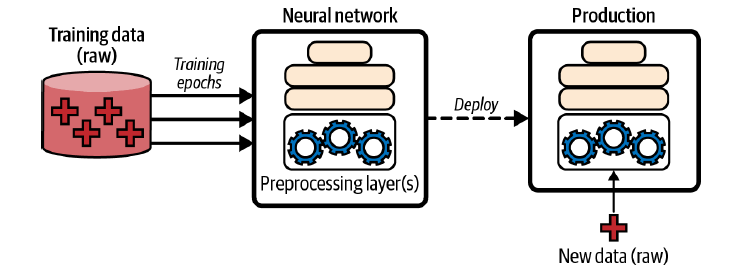 <br>

* Including the preprocessing layer in the model will slow down training, since preprocessing is performed on the fly during training, it happens once per epoch. A better approach is by normalizing the whole training set just once before training. 
    * To do this use the `Normalization` layer in a standalone fashion.
    * Since the model won't preprocess its input when it is deployed to production, we need to create a new model that wraps both the adapted `Normalization` layer and the model we just trained.
    * Then deploy this final model to production. <br>
    &emsp; 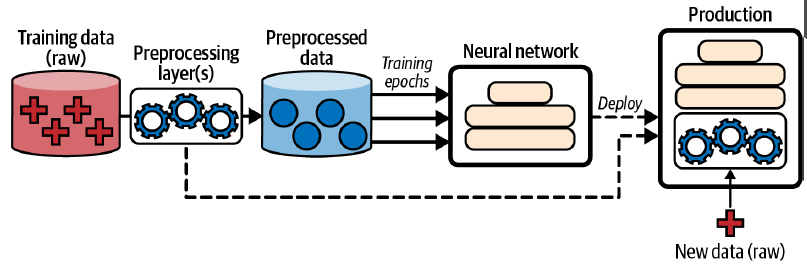 <br>

* Keras preprocessing layers play nicely w/ the `tf.data` API.
    * For example its possible to pass a `tf.data.Dataset` to a preprocessing layer's `adapt()` method.
    * It's also possible to apply a Keras preprocessing layer to a `tf.data.Dataset` using the dataset's `map()` method.

In [76]:
tf.random.set_seed(42)

norm_layer = tf.keras.layers.Normalization()

model = tf.keras.models.Sequential([
    norm_layer,
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
norm_layer.adapt(X_train) # computes the mean and variance of every feature
model.fit(X_train, y_train, validation_data =(X_valid, y_valid), epochs=5)

Epoch 1/5
363/363 [==============================] - 2s 3ms/step - loss: 2.8330 - val_loss: 2.6294
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.8886 - val_loss: 1.7261
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.7527 - val_loss: 1.3951
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.7060 - val_loss: 0.9432
Epoch 5/5
363/363 [==============================] - 1s 2ms/step - loss: 0.6729 - val_loss: 0.6458


In [77]:
# Standalone Normalization Layer
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_scaled = norm_layer(X_train)
X_valid_scaled = norm_layer(X_valid)

# The normalization layer is now separated fro mthe model
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1)])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
363/363 [==============================] - 2s 3ms/step - loss: 2.6301 - val_loss: 1.1194
Epoch 2/5
105/363 [=======>......................] - ETA: 0s - loss: 0.7846

363/363 [==============================] - 1s 2ms/step - loss: 0.6465 - val_loss: 1.4703
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.5524 - val_loss: 1.0055
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.5425 - val_loss: 0.7071
Epoch 5/5
363/363 [==============================] - 1s 2ms/step - loss: 0.5403 - val_loss: 0.5080


In [78]:
# Wrap the final model w/ the trained model and norm layer 
final_model = tf.keras.Sequential([norm_layer, model])
X_new = X_test[:3]  # pretend  a few new instances (unscaled)
y_pred = final_model(X_new)  # preprocesses the data and makes predictions

In [79]:
y_pred

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.79239535],
       [1.7375488 ],
       [2.6046233 ]], dtype=float32)>

In [80]:
# applying keras preprocessing layer to a tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(5)
dataset = dataset.map(lambda X, y: (norm_layer(X), y))

In [81]:
list(dataset.take(1))

[(<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
  array([[-0.19397898, -1.0778134 , -0.94338703,  0.01485134,  0.02073434,
          -0.5729169 ,  0.9292575 , -1.4221283 ],
         [ 0.7519828 , -1.8688954 ,  0.40547714, -0.23327859,  1.8614666 ,
           0.20516504, -0.91655123,  1.0966992 ],
         [-0.4146912 ,  0.02970134,  0.8180874 ,  1.0567816 , -0.08786613,
          -0.29983333,  1.3087244 , -1.6970019 ],
         [ 1.7188952 , -1.315138  ,  0.3266428 , -0.21955286, -0.337921  ,
          -0.11146676, -0.982138  ,  0.94177264],
         [-0.96207213, -1.2360299 , -0.05625897, -0.03124575,  1.709061  ,
          -0.3025704 , -0.8041154 ,  1.3265917 ]], dtype=float32)>,
  <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
  array([[1.442],
         [1.687],
         [1.621],
         [2.621],
         [0.956]])>)]

In [82]:
# Create a custom preprocessing layer
class MyNormalization(tf.keras.layers.Layer):
    def adapt(self, X):
        self.mean_ = np.mean(X, axis=0, keepdims=True)
        self.std_ = np.std(X, axis=0, keepdims=True)

    def call(self, inputs):
        eps = tf.keras.backend.epsilon()  # a small smoothing term
        return (inputs - self.mean_) / (self.std_ + eps)

In [83]:
my_norm_layer = MyNormalization()
my_norm_layer.adapt(X_train)
X_train_scaled = my_norm_layer(X_train)

In [84]:
tf.reduce_mean(X_train_scaled)

<tf.Tensor: shape=(), dtype=float32, numpy=2.2178473e-07>

In [85]:
tf.math.reduce_std(X_train_scaled)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

### C.2. The Discretization Layer:

* The `Discretization` layer transforms a numerical feature into a categorical feature by mapping value ranges (bins) to categories.
    * This is sometimes useful for features w/ multimodal distributions, or w/ features that have a highly non-linear relationship w/ the target.
    * pass either the `bin_boundaries` or number of `num_bins`. For `num_bins`, call the layer's `adapt()` method to let it find the appropriate bin boundaries based on the value percentiles.

* Category identifiers such as these should generally not be passed directly to a neural network, as their values cannot be meaningfully compared. Instead, they should be encoded, for example using one-hot encoding.

In [86]:
age = tf.constant([[10.], [93.], [57.], [18.], [37.], [5.]])
discretize_layer = tf.keras.layers.Discretization(bin_boundaries=[18., 50.])
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[0],
       [2],
       [2],
       [1],
       [1],
       [0]], dtype=int64)>

In [87]:
discretize_layer = tf.keras.layers.Discretization(num_bins=3)
discretize_layer.adapt(age)
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[1],
       [2],
       [2],
       [1],
       [2],
       [0]], dtype=int64)>

### C.3. The `CategoryEncoding` Layer:

* When there are only a few categories (e.g., less than a dozen or two), then one-hot encoding is often a good option. Keras provides the `CategoryEncoding` layer for this task.

In [88]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3)
onehot_layer(age_categories)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>

In [89]:
# Multi-hot encoding
two_age_categories = np.array([[1, 0], [2, 2], [2, 0]])
onehot_layer(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 1.],
       [1., 0., 1.]], dtype=float32)>

In [90]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3, output_mode="count")
onehot_layer(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 2.],
       [1., 0., 1.]], dtype=float32)>

In [91]:
# Per feature one-hot encoding
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3 + 3)
onehot_layer(two_age_categories + [0, 3])  # adds 3 to the second feature

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

In [92]:
two_age_categories, two_age_categories + [0, 3]

(array([[1, 0],
        [2, 2],
        [2, 0]]),
 array([[1, 3],
        [2, 5],
        [2, 3]]))

### C.4. The StringLookup Layer:

* `StringLookup()`:
    * For encoding categorical text features. Unknown categories get mapped to 0. The known categories are numbered starting at 1, from the most frequent category to the least frequent.
    * Ouput a one-hot vector for each category instead of an integer by setting `output_mode="one_hot"`

* Keras also includes an `IntegerLookup` layer that acts much like the `StringLookup` layer but takes integers as input, rather than strings.

* If the training set is very large, it may be convenient to adapt the layer to just a random subset of the training set. In this case, the layer’s `adapt()` method may miss some of the rarer categories. By default, it would then map them all to category 0, making them indistinguishable by the model.
    * To reduce this risk (while still adapting the layer only on a subset of the training set), set `num_oov_indices` to an integer greater than 1.
    * This is the number of out-of-vocabulary (OOV) buckets to use: each unknown category will get mapped pseudorandomly to one of the OOV buckets, using a hash function modulo the number of OOV buckets. This will allow the model to distinguish at least some of the rare categories.
    * *Hashing Collision*:
        * When 2 different categories are mapped to the same bucket. To reduce the risk of collision , increase the number of OOV buckets. However, this will also increase the total number of categories, which will require more RAM and extra model parameters once the categories are one-hot encoded. So, don’t increase that number too much.

In [93]:
cities = ["Auckland", "Paris", "Paris", "San Francisco"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[1],
       [3],
       [3],
       [0]], dtype=int64)>

In [94]:
str_lookup_layer = tf.keras.layers.StringLookup(num_oov_indices=5)
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Foo"], ["Bar"], ["Baz"]])

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[5],
       [7],
       [4],
       [3],
       [4]], dtype=int64)>

In [95]:
str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)>